# Taxi Cost Prediction using Linear Regression 

In [1]:
import numpy as np
from sklearn import datasets, linear_model, metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [2]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

# 1. Data Loading and Cleaning 

In [4]:
start = datetime.now()
# taxiOrdersDF is feature set 
taxiOrdersDF = pd.read_csv('./orders_2019.csv', sep=';', 
                           usecols=["id","tariffID", "payment_type_id"],
                           encoding = 'UTF-8')

# taxiOrdersDetailsDF is target value (label)  
taxiOrdersDetailsDF = pd.read_csv('./order_details_2019.csv', sep=';',
                                   usecols=["order_id", "total_cost", "driving_time",
                                            "driving_distance", "distance_cost_per_km"], encoding = 'UTF-8')
print("Computing time takes %s" %(datetime.now()-start))

Computing time takes 0:00:03.074262


### Info about data

In [5]:
print(taxiOrdersDF.columns)
print(taxiOrdersDetailsDF.columns)

Index(['id', 'tariffID', 'payment_type_id'], dtype='object')
Index(['order_id', 'driving_time', 'distance_cost_per_km', 'total_cost',
       'driving_distance'],
      dtype='object')


In [6]:
taxiOrdersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697585 entries, 0 to 697584
Data columns (total 3 columns):
id                 697585 non-null int64
tariffID           697585 non-null int64
payment_type_id    697585 non-null int64
dtypes: int64(3)
memory usage: 16.0 MB


### Checking missing records which contains null values, they should be cleaned 

In [7]:
side_by_side(taxiOrdersDF.isnull().sum(), taxiOrdersDF.count())

id                 0    id                 697585
tariffID           0    tariffID           697585
payment_type_id    0    payment_type_id    697585
dtype: int64            dtype: int64             



In [8]:
side_by_side(taxiOrdersDetailsDF.isnull().sum(), taxiOrdersDetailsDF.count())

order_id                0    order_id                498787
driving_time            0    driving_time            498787
distance_cost_per_km    0    distance_cost_per_km    498787
total_cost              0    total_cost              498787
driving_distance        0    driving_distance        498787
dtype: int64                 dtype: int64                  



### Let's join these two tables

In [9]:
taxiOrdersDF['id'] = taxiOrdersDF['id'].astype('int64')
taxiOrdersDF.rename(columns={'id':'order_id'}, inplace=True)
taxiOrdersJoinTotalCostDF = pd.merge(taxiOrdersDF, taxiOrdersDetailsDF, on='order_id', how='inner')

In [10]:
side_by_side(taxiOrdersJoinTotalCostDF.isnull().sum(), taxiOrdersJoinTotalCostDF.count())

order_id                0    order_id                498786
tariffID                0    tariffID                498786
payment_type_id         0    payment_type_id         498786
driving_time            0    driving_time            498786
distance_cost_per_km    0    distance_cost_per_km    498786
total_cost              0    total_cost              498786
driving_distance        0    driving_distance        498786
dtype: int64                 dtype: int64                  



In [11]:
taxiOrdersJoinTotalCostDF.drop(["order_id"], axis=1, inplace = True) 
taxiOrdersDF = taxiOrdersJoinTotalCostDF # rename taxiOrdersJoinTotalCostDF 

# 2. Data Wrangling and Features Engineering


In [12]:
taxiOrdersDF.describe().T 

,count,mean,std,min,25%,50%,75%,max
tariffID,498786.0,12.491658,16.466151,1.0,1.0,1.0,29.0,69.0
payment_type_id,498786.0,1.118428,0.413726,1.0,1.0,1.0,1.0,4.0
driving_time,498786.0,1063.402658,966.063730,0.0,540.0,850.0,1291.0,54386.0
distance_cost_per_km,498786.0,1259.211265,160.005550,800.0,1200.0,1200.0,1200.0,4000.0
total_cost,498786.0,15948.863665,51353.618045,2000.0,9100.0,13000.0,18600.0,8388607.0
driving_distance,498786.0,7961.282564,24457.078745,0.0,3971.0,6704.0,10356.0,8388607.0


### Correlation between data

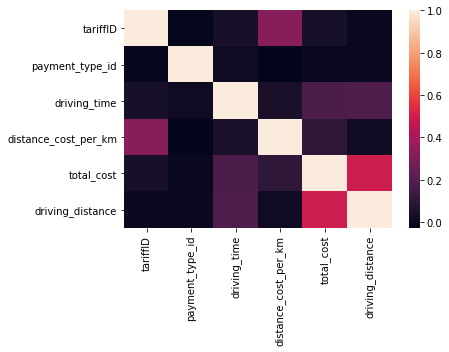

In [13]:
corr = taxiOrdersDF.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# 3. Training and Evaluating Machine Learning Model

In [14]:
taxiOrdersDF.shape

(498786, 6)

In [15]:
taxiOrdersDF.columns

Index(['tariffID', 'payment_type_id', 'driving_time', 'distance_cost_per_km',
       'total_cost', 'driving_distance'],
      dtype='object')

In [18]:
taxiOrders_Y = taxiOrdersDF["total_cost"]
taxiOrders_X = taxiOrdersDF
taxiOrders_X.drop(["total_cost"], axis=1, inplace = True) 

# Split the data into training/testing sets
taxiOrders_X_train = taxiOrders_X[:-200]
taxiOrders_X_test = taxiOrders_X[-200:]

# Split the targets into training/testing sets
taxiOrders_Y_train = taxiOrders_Y[:-200]
taxiOrders_Y_test = taxiOrders_Y[-200:]

### 3.1 Train